In [1]:
##### Machine learning

# import sys
# !conda install --yes --prefix {sys.prefix} fbprophet


In [2]:
###All models
# Linear model
from sklearn.linear_model import LinearRegression
# Non-linear model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#Statistical auto-regressive model
from statsmodels.tsa.statespace.sarimax import SARIMAX
#Statistical packaged model << imported down the cells>> from fbprophet import Prophet
from fbprophet.forecaster import Prophet

####Other libraries
import pandas as pd
import numpy as np
from datetime import datetime
import random
from itertools import product
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')


In [3]:
##### to print multiple outputs from same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Statistical packaged model
# from fbprophet import Prophet

In [4]:
df = pd.read_csv('/Users/tejasvibelsare/Documents/DM term project/all.csv')

df['Date'] = pd.to_datetime(df['Date'])

holidays = sorted(df.query('IsHoliday==True').DateString.unique())
stores = sorted(df.Store.unique())

[0.98843164 0.98843164 0.98843164 ... 1.06863643 1.06863643 1.06863643]
LinearRegression MAE=1017.5395935596372 WMAE=1039.7312909548834 MAPE= 7.019676348122415 RMSE=1424.4451661995697 


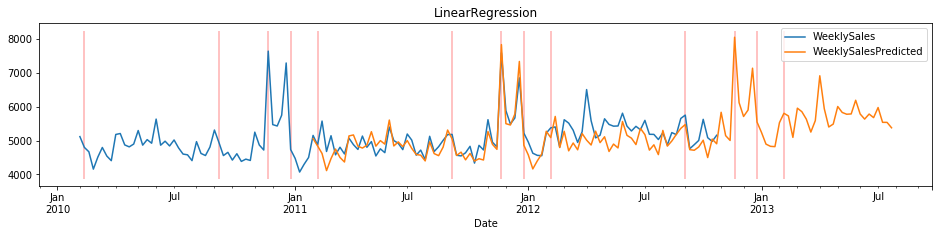

[0.97392894 0.97392894 0.97392894 ... 1.02218793 1.02218793 1.02218793]
RandomForestRegressor MAE=920.657943311092 WMAE=915.7828502952425 MAPE= 6.656631355692808 RMSE=1269.29252487739 


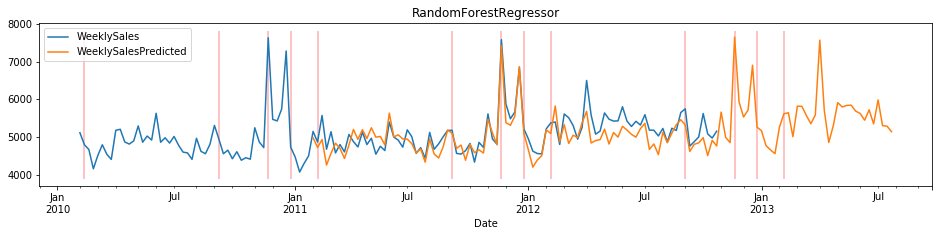

[0.98457701 0.98457701 0.98457701 ... 1.02492778 1.02492778 1.02492778]
GradientBoostingRegressor MAE=972.2795611088 WMAE=964.7397467848089 MAPE= 6.801196902353718 RMSE=1368.703285592173 


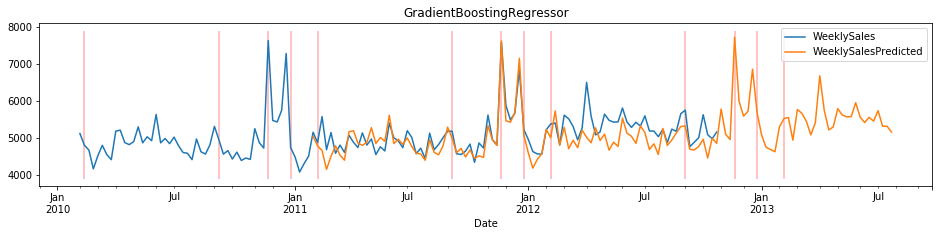

In [5]:
# from sklearn.linear_model import LinearRegression #, ElasticNet
# # from sklearn.neural_network import MLPRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# # from xgboost import XGBRegressor
# # from sklearn.svm import SVR
# # from sklearn.dummy import DummyRegressor
# import random

train_stores = random.sample(stores, int(len(stores)*0.75))
test_stores = [s for s in stores if s not in train_stores]

def forecast_sales(regressor, train_start="2011-05", train_end="2012-43", forecast_start="2012-44"):
    
    store_dummies = ['Store_%s'%i for i in sorted(df.Store.unique())]
    features = ['Year', 'Week', 'IsHoliday'] + store_dummies
    
    # perform training on the training set
    
    df_train = df[(df.YearWeek>=train_start) & (df.YearWeek<=train_end) & (df.Store.isin(train_stores))]
    
    X = df_train[features].values
    y = df_train['WeeklySalesIncreaseRatio'].values
    regressor.fit(X,y)
    
    # perform predictions on the test set
    
    dff = df[df.Store.isin(test_stores)].copy()
    
    pred_idx = (dff.YearWeek>=train_start) 
    df_pred = dff[pred_idx]

    X_pred = df_pred[features].values
    y_pred = regressor.predict(X_pred)

#   print(df_pred[features])
    print(y_pred)
    dff.loc[pred_idx, 'WeeklySalesIncreaseRatioPredicted'] = y_pred    
    dff.loc[pred_idx, 'WeeklySalesPredicted'] = df_pred['WeeklySalesPreviousYear'] * y_pred
    
    
    dfm = dff[(dff.YearWeek>=train_start) & (dff.YearWeek<=train_end)]
    y_pred = dfm.WeeklySalesPredicted.values
    y_actual = dfm.WeeklySales.values
    w = dfm.IsHoliday.map(lambda v: 5 if v else 1).values

#   print(dfm)
    rmse = np.sqrt(np.mean((y_pred-y_actual)**2))    
    wmae = np.sum(w*(np.abs(y_pred-y_actual))) / np.sum(w)
    mae = np.mean(np.abs(y_pred-y_actual))
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
        
    return mae, wmae, rmse, dff, mape

for reg in [LinearRegression(), RandomForestRegressor(),GradientBoostingRegressor()]:
        
    name = type(reg).__name__
    mae, wmae, rmse, dff, mape = forecast_sales(reg)

    print("%s MAE=%s WMAE=%s MAPE= %s RMSE=%s " % (name, mae, wmae, mape, rmse))
  
    ax  = dff[dff.Store==test_stores[0]].plot(x='Date', y=['WeeklySales','WeeklySalesPredicted'], figsize=(16,3), title=name)
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=holidays, ymin=ymin, ymax=ymax-1, color='#ffb0b0')
    plt.show()
    

In [6]:
##### SARIMAX

In [7]:
df1 = df.copy().query("Store==1 and Train")
df1_idx = df1.set_index(['Date'])
df1_sales = df1_idx['WeeklySales']

In [8]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from itertools import product
# from tqdm import tqdm_notebook as tqdm
# import warnings
# warnings.filterwarnings('ignore')

# ((p,d,q), metric)
best_rmse, best_mape, best_mae, best_wmae = None, None, None, None

for pdq_pdqs in tqdm(list(product(range(5), range(3), range(5), range(2), range(2), range(2), [52]))):
    
    pdq = (pdq_pdqs[0], pdq_pdqs[1], pdq_pdqs[2])
    pdqs = (pdq_pdqs[3], pdq_pdqs[4], pdq_pdqs[5], pdq_pdqs[6])
    
    try:
        model = SARIMAX(df1_sales, order=pdq, enforce_stationarity=False, enforce_invertibility=False, seasonal_order=pdqs)
        fit = model.fit(disp=0)
        y_actual = df1_idx.WeeklySales.values
        y_pred = fit.predict().values
        w = df1.IsHoliday.map(lambda v: 5 if v else 1).values
        
        rmse = np.sqrt(np.mean((y_pred-y_actual)**2))    
        mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
        mae = np.mean(np.abs(y_pred-y_actual))
        wmae = np.sum(w*(np.abs(y_pred-y_actual))) / np.sum(w)

        if best_rmse==None or abs(best_rmse[2]) > abs(rmse):
            best_rmse = (pdq, pdqs, rmse)
        if best_mape==None or abs(best_mape[2]) > abs(mape):
            best_mape = (pdq, pdqs, mape)
        if best_mae==None or abs(best_mae[2]) > abs(mae):
            best_mae = (pdq, pdqs, mae)     
        if best_wmae==None or abs(best_wmae[2]) > abs(wmae):
            best_wmae = (pdq, pdqs, wmae)
    except:
        #print("not valid: %s %s" % (str(pdq), str(pdqs)))
        continue


In [9]:
# print("Best RMSE: %s "  best_rmse)
# print("Best MAPE: %s "  best_mape)
# print("Best MAE: %s "  best_mae)

print("MAE=%s MAPE= %s RMSE=%s WMAE=%s" % (best_mae, best_mape, best_rmse, best_wmae))

MAE=((2, 1, 3), (1, 0, 0, 52), 1184.3626773974756) MAPE= ((2, 1, 3), (1, 0, 0, 52), 5.366400385394528) RMSE=((4, 1, 1), (1, 0, 0, 52), 2539.439508192969) WMAE=((2, 1, 1), (1, 0, 0, 52), 1428.6727227868428)


In [10]:
# best_mae = ((2, 1, 3), (1, 0, 0, 52), 1184.3626773974756)
# best_mape = ((2, 1, 3), (1, 0, 0, 52), 5.366400385394528)
# best_rmse = ((4, 1, 1), (1, 0, 0, 52), 2539.439508192969)
# best_wmae = ((2, 1, 1), (1, 0, 0, 52), 1428.6727227868428)


In [11]:
# from tqdm import tqdm_notebook as tqdm
# from statsmodels.tsa.statespace.sarimax import SARIMAX
dfa = df.copy()[['Date', 'WeeklySales', 'Store', 'IsHoliday']]
dfa['WeeklySalesForecast'] = np.nan

# many convergency warnings are expected, so let's disable warnings
# import warnings
# warnings.filterwarnings('ignore')

for store in tqdm(stores):
    
    # fit the model using past sales and perform in-sample forecasts
    idx = (df.Store==store) & (df.WeeklySales.notnull())
    X = dfa[idx].WeeklySales.values
    model = SARIMAX(X, order=best_wmae[0], enforce_stationarity=False, enforce_invertibility=False, seasonal_order=best_wmae[1])
    fit = model.fit(disp=0)
    dfa.loc[idx, 'WeeklySalesForecast'] = fit.predict()
    
    # calculate out-of-sample forecasts
    idx = (df.Store==store) & (df.WeeklySales.isnull())
    X = dfa[idx].WeeklySales.values
    steps = len(dfa[idx])
    y_pred = fit.get_forecast(steps=39).predicted_mean
    dfa.loc[idx, 'WeeklySalesForecast'] = y_pred
    
# # re-enable warnings
# warnings.simplefilter('always')     

dfa['Residuals'] = dfa.WeeklySales - dfa.WeeklySalesForecast


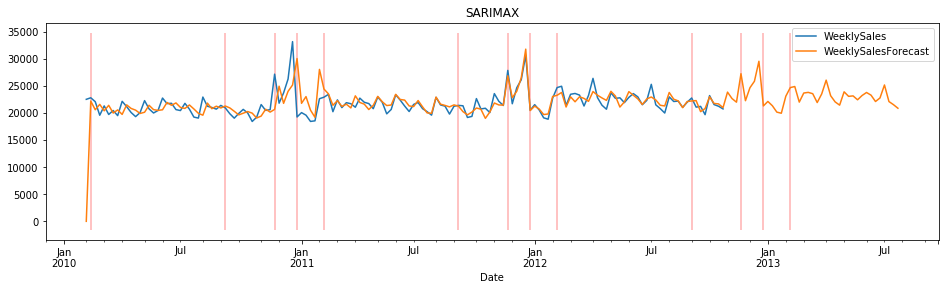

In [12]:
ax = dfa.query('Store==1').plot(x='Date', y=['WeeklySales','WeeklySalesForecast'], figsize=(16,4),title= 'SARIMAX')
ymin, ymax = ax.get_ylim()
ax.vlines(x=holidays, ymin=ymin, ymax=ymax-1, color='#ffb0b0')
plt.show()


In [13]:
y_actual = dfa.WeeklySales
y_pred = dfa.WeeklySalesForecast
w = dfa.IsHoliday.map(lambda v: 5 if v else 1).values

rmse = np.sqrt(np.mean((y_pred-y_actual)**2))    
wmae = np.sum(w*(np.abs(y_pred-y_actual))) / np.sum(w)
mae = np.mean(np.abs(y_pred-y_actual))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print("MAE=%s WMAE=%s RMSE=%s MAPE=%s" % (mae, wmae, rmse, mape))

MAE=1033.659985156808 WMAE=1067.6085703784684 RMSE=2414.0089931094603 MAPE=6.612580344064481


In [14]:
####### FBPROPHET

In [15]:
df = pd.read_csv('/Users/tejasvibelsare/Documents/DM term project/all.csv')

df['Date'] = pd.to_datetime(df['Date'])

holidays = sorted(df.query('IsHoliday==True').DateString.unique())
stores = sorted(df.Store.unique())

In [16]:
df1 = df.copy().query("Store==1 and Train")
df1_idx = df1.set_index(['Date'])
df1_sales = df1_idx['WeeklySales']

In [17]:
# from fbprophet import Prophet
# import warnings
# warnings.filterwarnings('ignore')

dfp = pd.DataFrame()

for store in stores:

    dfs = df[df.Store==store][['Date', 'WeeklySales', 'Store', 'IsHoliday']]
    df_prophet = dfs.copy().rename(columns={'Date':'ds', 'WeeklySales':'y'})

    m = Prophet(weekly_seasonality=False, daily_seasonality = False)
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods=40, freq='W')
    forecast = m.predict(future)

    dff = forecast.copy()[['ds','yhat']].rename(columns={'ds':'Date', 'yhat':'WeeklySalesForecast'})
    dfs = pd.merge(dfs, dff, on='Date', how='outer')
    dfp = pd.concat([dfp, dfs])

In [22]:
dff.head

<bound method NDFrame.head of           Date  WeeklySalesForecast
0   2010-02-05         11705.630662
1   2010-02-12         11815.247803
2   2010-02-19         11402.604476
3   2010-02-26         11157.113766
4   2010-03-05         11236.485287
5   2010-03-12         11353.203380
6   2010-03-19         11344.127330
7   2010-03-26         11387.657601
8   2010-04-02         11654.976643
9   2010-04-09         11967.476816
10  2010-04-16         11972.381887
11  2010-04-23         11608.979244
12  2010-04-30         11237.072673
13  2010-05-07         11243.639633
14  2010-05-14         11617.126936
15  2010-05-21         12003.611033
16  2010-05-28         12136.435743
17  2010-06-04         12088.028358
18  2010-06-11         12073.934157
19  2010-06-18         12127.504351
20  2010-06-25         12081.541041
21  2010-07-02         11834.018024
22  2010-07-09         11496.621700
23  2010-07-16         11229.177556
24  2010-07-23         11028.899415
25  2010-07-30         10799.52283

In [1]:
dfp['Residuals'] = dfp.WeeklySales - dfp.WeeklySalesForecast
ax = dfp[dfp.Store==8].plot(x='Date', y=['WeeklySales','WeeklySalesForecast'], figsize=(16,4))
ymin, ymax = ax.get_ylim()
ax.vlines(x=holidays, ymin=ymin, ymax=ymax-1, color='#ffb0b0')



NameError: name 'dfp' is not defined

In [19]:
y_actual = dfp.WeeklySales
y_pred = dfp.WeeklySalesForecast
w = dfp.IsHoliday.map(lambda v: 5 if v else 1).values

rmse = np.sqrt(np.mean((y_pred-y_actual)**2))  

wmae = np.sum(w*(np.abs(y_pred-y_actual))) / np.sum(w)

mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

mae = np.mean(np.abs(y_pred-y_actual))

print("MAE=%s MAPE=%s RMSE=%s WMAE=%s" % (mae, mape, rmse, wmae))

MAE=817.4678514147835 MAPE=5.057457232685563 RMSE=1423.3564970154646 WMAE=449.72304724356866


In [20]:
#with weekly seasonality
# MAE=817.6394740405223 MAPE=5.0584272347987955 RMSE=1423.554315567884 WMAE=449.72005144899157